In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter as fsf
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter as fsf
from matplotlib.gridspec import GridSpec
from plots.mpltoolkit import (named_colors, mpl_loc,
    fancy_legend, load_mpl_presets, append_axes, markers, append_axes)
import vice
# from vice.yields.presets import JW20
import numpy as np
import math as m
import sys
sys.path.append("..")
from src.utils import exponential
load_mpl_presets()
print(sys.version_info)

/Users/astrobeard/Work/Research/VICErepos/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=10, micro=2, releaselevel='final', serial=0)


In [5]:
raw = np.genfromtxt("../mocksamples/fiducial.dat")
mock = vice.dataframe({})
mock["[fe/h]"] = raw[:, 0]
mock["[fe/h]_err"] = raw[:, 1]
mock["[o/fe]"] = raw[:, 2]
mock["[o/fe]_err"] = raw[:, 3]
mock["age"] = [10**_ for _ in raw[:, 4]]
mock["age_err"] = [a * b * m.log(10) for a, b in zip(mock["age"], raw[:, 5])]

/Users/astrobeard/Work/Research/VICErepos/VICE/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: func
  warnings.warn("""\
/var/folders/1p/lm_h7y810f9_7ygnvr2tjc_w0000gn/T/ipykernel_25932/333477135.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


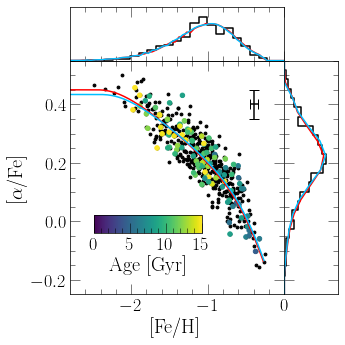

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("[Fe/H]")
ax.set_ylabel(r"[$\alpha$/Fe]")
ax.set_xlim([-2.8, 0])
ax.set_ylim([-0.25, 0.55])

kwargs = {
    "c": named_colors()["black"],
    "s": 8
}
ax.scatter(mock["[fe/h]"], mock["[o/fe]"], **kwargs)
kwargs["s"] = 20
kwargs["c"] = mock["age"]
kwargs["cmap"] = "viridis"
kwargs["vmin"] = 0
kwargs["vmax"] = 15
sc = ax.scatter(mock["[fe/h]"], mock["[o/fe]"], **kwargs)
cbar_ax = fig.add_axes([0.27, 0.32, 0.3, 0.05])
cbar = plt.colorbar(sc, cax = cbar_ax, pad = 0, orientation = "horizontal")
cbar.set_label("Age [Gyr]", labelpad = 3)
cbar.set_ticks(range(0, 16, 5))
ax.errorbar(-0.4, 0.4, xerr = 0.05, yerr = 0.05, c = named_colors()["black"])

top = fig.add_axes([0.1, 0.9, 0.8, 0.1])
right = fig.add_axes([0.9, 0.1, 0.1, 0.8])
plt.setp(top.get_xticklabels(), visible = False)
plt.setp(top.get_yticklabels(), visible = False)
plt.setp(right.get_xticklabels(), visible = False)
plt.setp(right.get_yticklabels(), visible = False)
top.set_xlim(ax.get_xlim())
top.set_ylim([0, 1.5])
top.tick_params(axis = "y", which = "both", left = False, right = False)
right.set_xlim([0, 5])
right.set_ylim(ax.get_ylim())
right.tick_params(axis = "x", which = "both", bottom = False, top = False)

kwargs = {
    "bins": 25,
    "range": ax.get_xlim(),
    "density": True
}
feh_dist, feh_bins = np.histogram(mock["[fe/h]"], **kwargs)
top.step(feh_bins[:-1], feh_dist, where = "post", c = named_colors()["black"])

kwargs["range"] = ax.get_ylim()
afe_dist, afe_bins = np.histogram(mock["[o/fe]"], **kwargs)
right.step(afe_dist, afe_bins[:-1], where = "pre", c = named_colors()["black"])

with vice.output("../mocksamples/fiducial") as true:
    kwargs = {
        "c": named_colors()["red"]
    }
    ax.plot(true.history["[fe/h]"], true.history["[o/fe]"], **kwargs)
    xvals = [(a + b) / 2 for a, b in zip(true.mdf["bin_edge_left"], true.mdf["bin_edge_right"])]
    top.plot(xvals, true.mdf["dn/d[fe/h]"], **kwargs)
    right.plot(true.mdf["dn/d[o/fe]"], xvals, **kwargs)
    
bf_duration = 9.59
with vice.singlezone(name = "./bestfit") as sz:
    sz.elements = ["fe", "o"]
    sz.func = exponential()
    sz.func.timescale = 1.86
    sz.mode = "ifr"
    sz.dt = bf_duration / 1000
    sz.Mg0 = 0
    sz.nthreads = 2
    sz.eta = 9.99
    sz.tau_star = 14.24
    vice.yields.ccsne.settings['o'] = 0.01
    vice.yields.sneia.settings['o'] = 0
    vice.yields.ccsne.settings['fe'] = 0.83 / 1000
    vice.yields.sneia.settings['fe'] = 1.04 / 1000
    bfout = sz.run(np.linspace(0, bf_duration, 1001), overwrite = True, capture = True)
    
kwargs = {"c": named_colors()["deepskyblue"]}
ax.plot(bfout.history["[fe/h]"], bfout.history["[o/fe]"], **kwargs)
xvals = [(a + b) / 2 for a, b in zip(bfout.mdf["bin_edge_left"], bfout.mdf["bin_edge_right"])]
top.plot(xvals, bfout.mdf["dn/d[fe/h]"], **kwargs)
right.plot(bfout.mdf["dn/d[o/fe]"], xvals, **kwargs)

plt.tight_layout()
plt.subplots_adjust(right = 0.8, top = 0.8)
top.set_position([
    ax.get_position().x0,
    ax.get_position().y1,
    ax.get_position().x1 - ax.get_position().x0,
    0.15
])
right.set_position([
    ax.get_position().x1,
    ax.get_position().y0,
    0.15,
    ax.get_position().y1 - ax.get_position().y0
])
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("../paper/fiducial_mock_afe_feh.%s" % (ext), **kwargs)
plt.show()

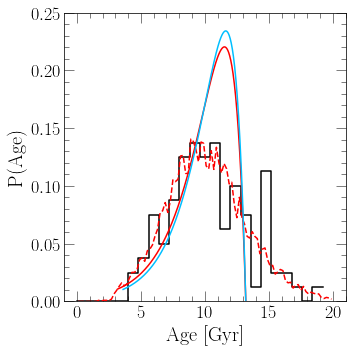

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Age [Gyr]")
ax.set_ylabel("P(Age)")
ax.set_xlim([-1, 21])
ax.set_ylim([0, 0.25])
# ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2])

kwargs = {
    "bins": 25,
    "range": [0, 20],
    "density": True
}
age_dist, age_bins = np.histogram(mock["age"], **kwargs)
ax.step(age_bins[:-1], age_dist, where = "post", c = named_colors()["black"])

with vice.output("../mocksamples/fiducial") as true:
    diff = 13.2 - true.history["time"][-1]
    xvals = [_ + diff for _ in true.history["lookback"]]
    norm = sum(true.history["sfr"]) * (true.history["time"][1] - true.history["time"][0])
    yvals = [_ / norm for _ in true.history["sfr"]]
    ax.plot(xvals, yvals, c = named_colors()["red"])
    
    totsfr = sum(true.history["sfr"])
    sfrfrac = [_ / totsfr for _ in true.history["sfr"]]
    indeces = np.random.choice(list(range(len(sfrfrac))), p = sfrfrac, size = int(1e4))
    resampled = [diff + true.history["lookback"][indeces[_]] for _ in range(len(indeces))]
    resampled = [10**(m.log10(_) + np.random.normal(scale = 0.1)) for _ in resampled]
    dist, bins = np.histogram(resampled, bins = 100, range = [0, 20], density = True)
    xvals = [(a + b) / 2 for a, b in zip(bins[1:], bins[:-1])]
    ax.plot(xvals, dist, c = named_colors()["red"], linestyle = '--')
    
with vice.output("./bestfit") as bfout:
    diff = 13.2 - bfout.history["time"][-1]
    xvals = [_ + diff for _ in bfout.history["lookback"]]
    norm = sum(bfout.history["sfr"]) * (bfout.history["time"][1] - bfout.history["time"][0])
    yvals = [_ / norm for _ in bfout.history["sfr"]]
    ax.plot(xvals, yvals, c = named_colors()["deepskyblue"])

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("../paper/fiducial_mock_agedist.%s" % (ext), **kwargs)
plt.show()

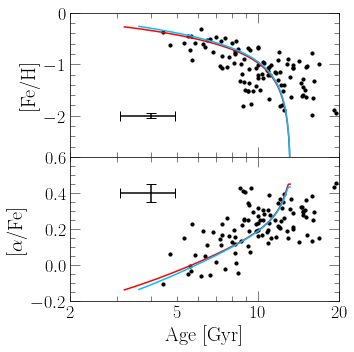

In [17]:
fig = plt.figure()
top = fig.add_subplot(211)
bottom = fig.add_subplot(212)
for ax in [top, bottom]:
    ax.set_xscale("log")
    ax.set_xlim([2, 20])
plt.setp(top.get_xticklabels(which = "both"), visible = False)
bottom.xaxis.set_major_formatter(fsf("%g"))
bottom.xaxis.set_minor_formatter(fsf("%g"))
top.set_ylim([-2.8, 0])
bottom.set_ylim([-0.2, 0.6])
bottom.set_xlabel("Age [Gyr]")
bottom.set_ylabel(r"[$\alpha$/Fe]")
top.set_ylabel("[Fe/H]")

kwargs = {
    "c": named_colors()["black"],
    "s": 10
#     "xerr": mock["age_err"],
#     "linestyle": "None"
}
top.scatter(mock["age"], mock["[fe/h]"], **kwargs)
bottom.scatter(mock["age"], mock["[o/fe]"], **kwargs)
# top.errorbar(mock["age"], mock["[fe/h]"], yerr = mock["[fe/h]_err"], **kwargs)
# bottom.errorbar(mock["age"], mock["[o/fe]"], yerr = mock["[o/fe]_err"], **kwargs)

bottom.set_xticks(range(2, 10), [str(_) if _ == 2 or _ == 5 else "" for _ in range(2, 10)], minor = True)
bottom.set_xticks([10, 20], minor = False)

ageval = 4
age_err = [[ageval - 10**(m.log10(ageval - 0.1 * ageval * m.log(10)))],
    [10**(m.log10(ageval + 0.1 * ageval * m.log(10))) - ageval]]
bottom.errorbar(ageval, 0.4, xerr = age_err, yerr = 0.05, c = named_colors()["black"])
top.errorbar(ageval, -2, xerr = age_err, yerr = 0.05, c = named_colors()["black"])

with vice.output("../mocksamples/fiducial") as true:
    diff = 13.2 - true.history["time"][-1]
    xvals = [_ + diff for _ in true.history["lookback"]]
    top.plot(xvals, true.history["[fe/h]"], c = named_colors()["red"])
    bottom.plot(xvals, true.history["[o/fe]"], c = named_colors()["red"])
    
with vice.output("./bestfit") as bfout:
    diff = 13.2 - bfout.history["time"][-1]
    xvals = [_ + diff for _ in bfout.history["lookback"]]
    top.plot(xvals, bfout.history["[fe/h]"], c = named_colors()["deepskyblue"])
    bottom.plot(xvals, bfout.history["[o/fe]"], c = named_colors()["deepskyblue"])

plt.tight_layout()
plt.subplots_adjust(hspace = 0, left = 0.2)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("../paper/fiducial_mock_amr.%s" % (ext), **kwargs)
plt.show()

In [2]:
true_values = [2, 10, 15, 10, 0.0008, 0.0011]
# for each sample size, the re-derived value, +error, and -error, in that order
rederived_samplesize = {
    20: [
        [2.55, 0.75, 0.45],
        [8.39, 1.11, 1.30],
        [14.35, 5.56, 3.32],
        [10.60, 1.65, 1.09],
        [0.00079, 0.00012, 0.00019],
        [0.00136, 0.00033, 0.00023]
    ],
    50: [
        [2.13, 0.42, 0.36],
        [10.39, 0.80, 0.76],
        [13.75, 2.79, 2.38],
        [11.25, 1.37, 1.76],
        [0.00083, 0.00006, 0.00006],
        [0.00095, 0.00014, 0.00014]
    ],
    100: [
        [2.06, 0.27, 0.26],
        [9.88, 0.64, 0.62],
        [15.06, 2.00, 1.79],
        [11.52, 1.06, 1.30],
        [0.00081, 0.00004, 0.00004],
        [0.00108, 0.00009, 0.00009]
    ],
    200: [
        [2.10, 0.18, 0.17],
        [10.11, 0.45, 0.43],
        [14.61, 1.34, 1.18],
        [10.60, 1.07, 0.86],
        [0.00077, 0.00003, 0.00003],
        [0.00114, 0.00007, 0.00007]
    ],
    500: [
        [1.84, 0.11, 0.11],
        [9.98, 0.30, 0.29],
        [14.01, 0.86, 0.84],
        [9.41, 0.63, 0.56],
        [0.00083, 0.00002, 0.00002],
        [0.00105, 0.00005, 0.00005]
    ],
    1000: [
        [2.05, 0.09, 0.08],
        [9.72, 0.20, 0.20],
        [14.62, 0.57, 0.56],
        [9.83, 0.38, 0.39],
        [0.00081, 0.00001, 0.00001],
        [0.00114, 0.00003, 0.00003]
    ],
    2000: [
        [2.00, 0.05, 0.05],
        [10.26, 0.15, 0.15],
        [15.82, 0.44, 0.42],
        [10.30, 0.25, 0.32],
        [0.00080, 0.00001, 0.00001],
        [0.00109, 0.00002, 0.00002]
    ]
}

rederived_abundanceprecision = {
    0.01: [
        [1.89, 0.10, 0.10],
        [10.25, 0.28, 0.28],
        [15.06, 0.52, 0.47],
        [9.70, 0.51, 0.59],
        [0.0008, 0.00001, 0.00001],
        [0.00109, 0.00002, 0.00002]
    ],
    0.02: [
        [1.92, 0.10, 0.09],
        [10.10, 0.25, 0.25],
        [14.71, 0.56, 0.55],
        [9.79, 0.45, 0.40],
        [0.00081, 0.00001, 0.00001],
        [0.00108, 0.00002, 0.00003]
    ],
    0.05: [
        [1.84, 0.11, 0.11],
        [9.98, 0.30, 0.29],
        [14.01, 0.86, 0.84],
        [9.41, 0.63, 0.56],
        [0.00083, 0.00002, 0.00002],
        [0.00105, 0.00005, 0.00005]
    ],
    0.1: [
        [2.00, 0.13, 0.12],
        [9.88, 0.31, 0.33],
        [13.39, 1.02, 1.02],
        [11.10, 1.00, 0.84],
        [0.00085, 0.00004, 0.00003],
        [0.00101, 0.00007, 0.00007]
    ],
    0.2: [
        [2.22, 0.21, 0.21],
        [9.83, 0.58, 0.67],
        [18.21, 2.19, 2.02],
        [10.32, 1.05, 0.67],
        [0.00087, 0.00007, 0.00007],
        [0.00105, 0.00014, 0.00014]
    ],
    0.5: [
        [2.73, 0.82, 0.60],
        [10.05, 1.22, 1.26],
        [12.52, 3.75, 3.35],
        [9.00, 1.26, 0.95],
        [0.00075, 0.00018, 0.00016],
        [0.00112, 0.00031, 0.00031]
    ]
}

rederived_ageprecision = {
    0.02: [
        [2.08, 0.09, 0.08],
        [9.84, 0.24, 0.26],
        [14.69, 0.50, 0.46],
        [10.41, 0.47, 0.41],
        [0.00081, 0.00002, 0.00002],
        [0.00111, 0.00005, 0.00004]
    ],
    0.05: [
        [1.96, 0.11, 0.11],
        [9.88, 0.32, 0.30],
        [15.70, 0.71, 0.68],
        [9.95, 0.63, 0.53],
        [0.0008, 0.00002, 0.00002],
        [0.00111, 0.00005, 0.00004]
    ],
    0.1: [
        [1.84, 0.11, 0.11],
        [9.98, 0.30, 0.29],
        [14.01, 0.86, 0.84],
        [9.41, 0.63, 0.56],
        [0.00083, 0.00002, 0.00002],
        [0.00105, 0.00005, 0.00005]
    ],
    0.2: [
        [2.20, 0.18, 0.17],
        [9.83, 0.28, 0.27],
        [15.19, 1.11, 1.11],
        [10.76, 0.85, 0.93],
        [0.0008, 0.00002, 0.00002],
        [0.00111, 0.00005, 0.00004]
    ],
    0.5: [
        [2.25, 0.20, 0.25],
        [9.86, 0.28, 0.30],
        [16.24, 1.44, 1.62],
        [11.38, 1.00, 1.34],
        [0.0008, 0.00002, 0.00002],
        [0.0011, 0.00005, 0.00005]
    ],
    1.0: [
        [1.69, 0.35, 0.32],
        [9.53, 0.29, 0.29],
        [12.38, 2.27, 2.08],
        [8.66, 1.86, 1.74],
        [0.00083, 0.00003, 0.00003],
        [0.00115, 0.00006, 0.00006]
    ]
}

rederived_agefrac = {
    0.0: [
        [1.65, 0.55, 0.37],
        [9.39, 0.30, 0.29],
        [11.80, 3.36, 2.44],
        [7.35, 2.62, 1.74],
        [0.00083, 0.00004, 0.00004],
        [0.00119, 0.00008, 0.00007]
    ],
    0.1: [
        [1.75, 0.16, 0.17],
        [10.06, 0.29, 0.28],
        [13.65, 1.22, 1.12],
        [8.84, 0.87, 0.87],
        [0.00084, 0.00002, 0.00002],
        [0.00106, 0.00005, 0.00005]
    ],
    0.2: [
        [1.84, 0.11, 0.11],
        [9.98, 0.30, 0.29],
        [14.01, 0.86, 0.84],
        [9.41, 0.63, 0.56],
        [0.00083, 0.00002, 0.00002],
        [0.00105, 0.00005, 0.00005]
    ],
    0.3: [
        [1.94, 0.11, 0.10],
        [9.80, 0.27, 0.28],
        [14.26, 0.74, 0.67],
        [9.89, 0.54, 0.48],
        [0.0008, 0.00002, 0.00002],
        [0.0011, 0.00004, 0.00004]
    ],
    0.4: [
        [1.91, 0.09, 0.10],
        [10.07, 0.32, 0.30],
        [16.79, 0.81, 0.83],
        [10.34, 0.61, 0.50],
        [0.00078, 0.00002, 0.00002],
        [0.00112, 0.00005, 0.00005]
    ],
    0.5: [
        [2.00, 0.10, 0.10],
        [10.16, 0.30, 0.29],
        [15.46, 0.70, 0.69],
        [9.83, 0.48, 0.40],
        [0.00078, 0.00002, 0.00002],
        [0.00112, 0.00005, 0.00004]
    ],
    0.6: [
        [2.18, 0.09, 0.09],
        [9.65, 0.27, 0.25],
        [14.25, 0.67, 0.64],
        [10.49, 0.44, 0.37],
        [0.00078, 0.00002, 0.00002],
        [0.00115, 0.00004, 0.00004]
    ],
    0.7: [
        [1.99, 0.08, 0.08],
        [9.81, 0.28, 0.27],
        [14.92, 0.68, 0.62],
        [10.25, 0.46, 0.37],
        [0.00081, 0.00002, 0.00002],
        [0.00108, 0.00004, 0.00004]
    ],
    0.8: [
        [2.06, 0.09, 0.09],
        [9.53, 0.29, 0.26],
        [15.18, 0.63, 0.59],
        [9.76, 0.36, 0.33],
        [0.00079, 0.00002, 0.00002],
        [0.00115, 0.00005, 0.00005]
    ],
    0.9: [
        [1.93, 0.08, 0.08],
        [10.41, 0.31, 0.31],
        [16.23, 0.73, 0.70],
        [10.03, 0.39, 0.33],
        [0.00077, 0.00002, 0.00002],
        [0.00114, 0.00004, 0.00004]
    ],
    1.0: [
        [2.13, 0.09, 0.09],
        [9.44, 0.28, 0.27],
        [15.67, 0.64, 0.60],
        [10.21, 0.35, 0.31],
        [0.0008, 0.00002, 0.00002],
        [0.00115, 0.00005, 0.00005]
    ]
}

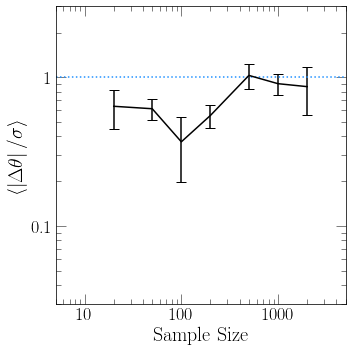

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xscale("log")
ax.set_yscale("log")
ax.xaxis.set_major_formatter(fsf("%g"))
ax.yaxis.set_major_formatter(fsf("%g"))
ax.set_xlabel("Sample Size")
ax.set_ylabel(r"$\langle\left|\Delta\theta\right|/\sigma\rangle$")
ax.set_xlim([5, 5000])
ax.set_ylim([0.03, 3])

yvals = []
errors = []
for samplesize in rederived_samplesize.keys():
    bestfits = rederived_samplesize[samplesize]
    deltas = len(true_values) * [0.]
    for i in range(len(deltas)):
        deltas[i] = abs(bestfits[i][0] - true_values[i])
        sigma = (bestfits[i][1] + bestfits[i][2]) / 2
        deltas[i] /= sigma
    yvals.append(np.mean(deltas))
    errors.append(np.std(deltas) / np.sqrt(len(deltas)))
    
xvals = list(rederived_samplesize.keys())
ax.errorbar(xvals, yvals, yerr = errors, c = named_colors()["black"])
ax.axhline(1, c = named_colors()["dodgerblue"], linestyle = ':')

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("../paper/dp_sigma_samplesize.%s" % (ext), **kwargs)
plt.show()

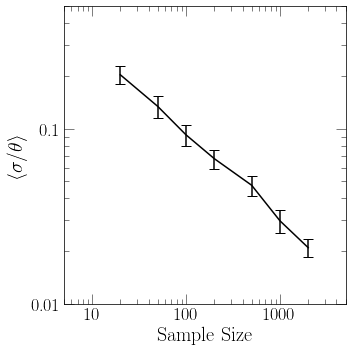

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xscale("log")
ax.set_yscale("log")
ax.xaxis.set_major_formatter(fsf("%g"))
ax.yaxis.set_major_formatter(fsf("%g"))
ax.set_xlabel("Sample Size")
# ax.set_ylabel(r"$\langle\left|\Delta\theta\right|/\sigma\rangle$")
ax.set_ylabel(r"$\langle\sigma/\theta\rangle$")
ax.set_xlim([5, 5000])
ax.set_ylim([0.01, 0.5])
# ax.set_ylim([0.03, 3])
    
yvals = []
errors = []
for samplesize in rederived_samplesize.keys():
    bestfits = rederived_samplesize[samplesize]
    precisions = []
    for i in range(len(true_values)):
        sigma = (bestfits[i][1] + bestfits[i][2]) / 2
        precisions.append(sigma / bestfits[i][0])
    yvals.append(np.mean(precisions))
    errors.append(np.std(precisions) / np.sqrt(len(precisions)))
    
xvals = list(rederived_samplesize.keys())
ax.errorbar(xvals, yvals, yerr = errors, c = named_colors()["black"])

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("../paper/precision_samplesize.%s" % (ext), **kwargs)
plt.show()

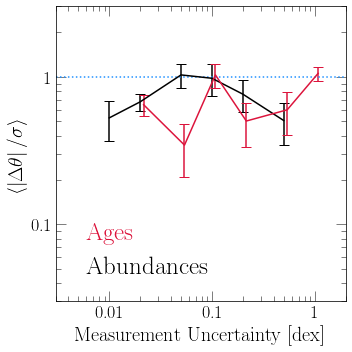

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xscale("log")
ax.set_yscale("log")
ax.xaxis.set_major_formatter(fsf("%g"))
ax.yaxis.set_major_formatter(fsf("%g"))
ax.set_xlabel("Measurement Uncertainty [dex]")
ax.set_ylabel(r"$\langle\left|\Delta\theta\right|/\sigma\rangle$")
ax.set_xlim([0.003, 2])
ax.set_ylim([0.03, 3])

yvals = []
errors = []
for samplesize in rederived_abundanceprecision.keys():
    bestfits = rederived_abundanceprecision[samplesize]
    deltas = len(true_values) * [0.]
    for i in range(len(deltas)):
        deltas[i] = abs(bestfits[i][0] - true_values[i])
        sigma = (bestfits[i][1] + bestfits[i][2]) / 2
        deltas[i] /= sigma
    yvals.append(np.mean(deltas))
    errors.append(np.std(deltas) / np.sqrt(len(deltas)))
    
xvals = list(rederived_abundanceprecision.keys())
ax.errorbar(xvals, yvals, yerr = errors, c = named_colors()["black"])

yvals = []
errors = []
for samplesize in rederived_ageprecision.keys():
    bestfits = rederived_ageprecision[samplesize]
    deltas = len(true_values) * [0.]
    for i in range(len(deltas)):
        deltas[i] = abs(bestfits[i][0] - true_values[i])
        sigma = (bestfits[i][1] + bestfits[i][2]) / 2
        deltas[i] /= sigma
    yvals.append(np.mean(deltas))
    errors.append(np.std(deltas) / np.sqrt(len(deltas)))

xvals = [_ * 1.08 for _ in list(rederived_ageprecision.keys())]
ax.errorbar(xvals, yvals, yerr = errors, c = named_colors()["crimson"])

ax.axhline(1, c = named_colors()["dodgerblue"], linestyle = ':')

ax.plot([1e-5, 1e-4], [1e-5, 1e-4], c = named_colors()["crimson"],
    label = "Ages")
ax.plot([1e-5, 1e-4], [1e-5, 1e-4], c = named_colors()["black"],
    label = "Abundances")

kwargs = {
    "loc": mpl_loc("lower left"),
    "handlelength": 0,
    "fontsize": 25
}
leg = ax.legend(**kwargs)
fancy_legend(leg, ["crimson", "black"])

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("../paper/dp_sigma_precision.%s" % (ext), **kwargs)
plt.show()

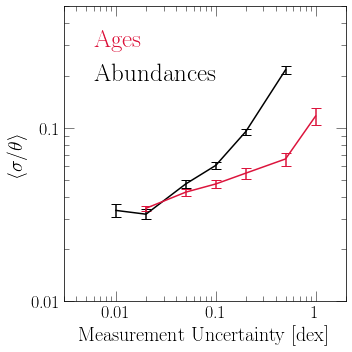

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xscale("log")
ax.set_yscale("log")
ax.xaxis.set_major_formatter(fsf("%g"))
ax.yaxis.set_major_formatter(fsf("%g"))
ax.set_xlabel("Measurement Uncertainty [dex]")
ax.set_ylabel(r"$\langle\sigma/\theta\rangle$")
ax.set_xlim([0.003, 2])
ax.set_ylim([0.01, 0.5])
    
yvals = []
errors = []
for precision in rederived_abundanceprecision.keys():
    bestfits = rederived_abundanceprecision[precision]
    precisions = []
    for i in range(len(true_values)):
        sigma = (bestfits[i][1] + bestfits[i][2]) / 2
        precisions.append(sigma / bestfits[i][0])
    yvals.append(np.mean(precisions))
    errors.append(np.std(precisions) / len(true_values))
        
    
xvals = list(rederived_abundanceprecision.keys())
ax.errorbar(xvals, yvals, yerr = errors, c = named_colors()["black"])

yvals = []
errors = []
for precision in rederived_ageprecision.keys():
    bestfits = rederived_ageprecision[precision]
    precisions = []
    for i in range(len(true_values)):
        sigma = (bestfits[i][1] + bestfits[i][2]) / 2
        precisions.append(sigma / bestfits[i][0])
    yvals.append(np.mean(precisions))
    errors.append(np.std(precisions) / len(true_values))

# xvals = [_ * 1.08 for _ in list(rederived_ageprecision.keys())]
xvals = list(rederived_ageprecision.keys())
ax.errorbar(xvals, yvals, yerr = errors, c = named_colors()["crimson"])

ax.plot([1e-5, 1e-4], [1e-5, 1e-4], c = named_colors()["crimson"],
    label = "Ages")
ax.plot([1e-5, 1e-4], [1e-5, 1e-4], c = named_colors()["black"],
    label = "Abundances")

kwargs = {
    "loc": mpl_loc("upper left"),
    "handlelength": 0,
    "fontsize": 25
}
leg = ax.legend(**kwargs)
fancy_legend(leg, ["crimson", "black"])

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("../paper/precision_uncertainty.%s" % (ext), **kwargs)
plt.show()

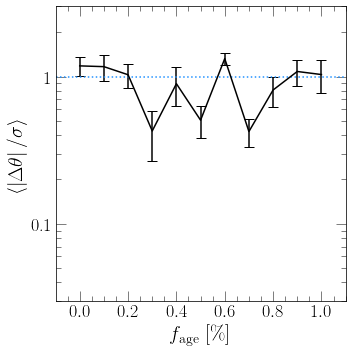

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.set_xscale("log")
ax.set_yscale("log")
# ax.xaxis.set_major_formatter(fsf("%g"))
ax.yaxis.set_major_formatter(fsf("%g"))
ax.set_xlabel(r"$f_\text{age}$ [\%]")
ax.set_ylabel(r"$\langle\left|\Delta\theta\right|/\sigma\rangle$")
ax.set_xlim([-0.1, 1.1])
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylim([0.03, 3])

yvals = []
errors = []
for samplesize in rederived_agefrac.keys():
    bestfits = rederived_agefrac[samplesize]
    deltas = len(true_values) * [0.]
    for i in range(len(deltas)):
        deltas[i] = abs(bestfits[i][0] - true_values[i])
        sigma = (bestfits[i][1] + bestfits[i][2]) / 2
        deltas[i] /= sigma
    yvals.append(np.mean(deltas))
    errors.append(np.std(deltas) / np.sqrt(len(deltas)))
    
xvals = list(rederived_agefrac.keys())
ax.errorbar(xvals, yvals, yerr = errors, c = named_colors()["black"])
ax.axhline(1, c = named_colors()["dodgerblue"], linestyle = ':')

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("../paper/dp_sigma_agefrac.%s" % (ext), **kwargs)
plt.show()

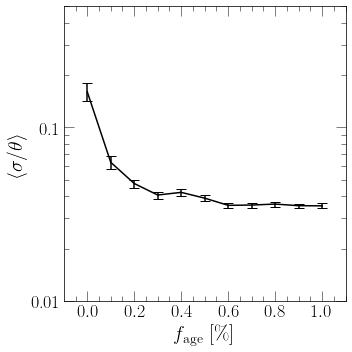

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.set_xscale("log")
ax.set_yscale("log")
# ax.xaxis.set_major_formatter(fsf("%g"))
ax.yaxis.set_major_formatter(fsf("%g"))
ax.set_xlabel(r"$f_\text{age}$ [\%]")
ax.set_ylabel(r"$\langle\sigma/\theta\rangle$")
ax.set_xlim([-0.1, 1.1])
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylim([0.01, 0.5])

yvals = []
errors = []
for agefrac in rederived_agefrac.keys():
    bestfits = rederived_agefrac[agefrac]
    precisions = []
    for i in range(len(true_values)):
        sigma = (bestfits[i][1] + bestfits[i][2]) / 2
        precisions.append(sigma / bestfits[i][0])
    yvals.append(np.mean(precisions))
    errors.append(np.std(precisions) / len(true_values))

xvals = list(rederived_agefrac.keys())
ax.errorbar(xvals, yvals, yerr = errors, c = named_colors()["black"])

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("../paper/precision_agefrac.%s" % (ext), **kwargs)
plt.show()